In [1]:
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from PIL import Image
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import accuracy_score
np.random.seed(42)

from matplotlib import style
style.use('fivethirtyeight')

In [2]:
print(os.getcwd())

C:\Users\Arnold\PycharmProjects\pythonProject


In [21]:
os.chdir("D:/trafficsigndataset")

In [22]:
print(os.getcwd())

D:\trafficsigndataset


In [23]:
data_dir = 'D:/trafficsigndataset'
train_path = 'D:/trafficsigndataset/Train'
test_path = 'D:/trafficsigndataset/Test'

IMG_HEIGHT = 30
IMG_WIDTH = 30
channels = 3

In [24]:
NUM_CATEGORIES = len(os.listdir(train_path))
NUM_CATEGORIES

43

In [25]:
classes = { 0:'Speed limit (20km/h)',
            1:'Speed limit (30km/h)',
            2:'Speed limit (50km/h)',
            3:'Speed limit (60km/h)',
            4:'Speed limit (70km/h)',
            5:'Speed limit (80km/h)',
            6:'End of speed limit (80km/h)',
            7:'Speed limit (100km/h)',
            8:'Speed limit (120km/h)',
            9:'No passing',
            10:'No passing veh over 3.5 tons',
            11:'Right-of-way at intersection',
            12:'Priority road',
            13:'Yield',
            14:'Stop',
            15:'No vehicles',
            16:'Veh > 3.5 tons prohibited',
            17:'No entry',
            18:'General caution',
            19:'Dangerous curve left',
            20:'Dangerous curve right',
            21:'Double curve',
            22:'Bumpy road',
            23:'Slippery road',
            24:'Road narrows on the right',
            25:'Road work',
            26:'Traffic signals',
            27:'Pedestrians',
            28:'Children crossing',
            29:'Bicycles crossing',
            30:'Beware of ice/snow',
            31:'Wild animals crossing',
            32:'End speed + passing limits',
            33:'Turn right ahead',
            34:'Turn left ahead',
            35:'Ahead only',
            36:'Go straight or right',
            37:'Go straight or left',
            38:'Keep right',
            39:'Keep left',
            40:'Roundabout mandatory',
            41:'End of no passing',
            42:'End no passing veh > 3.5 tons' }

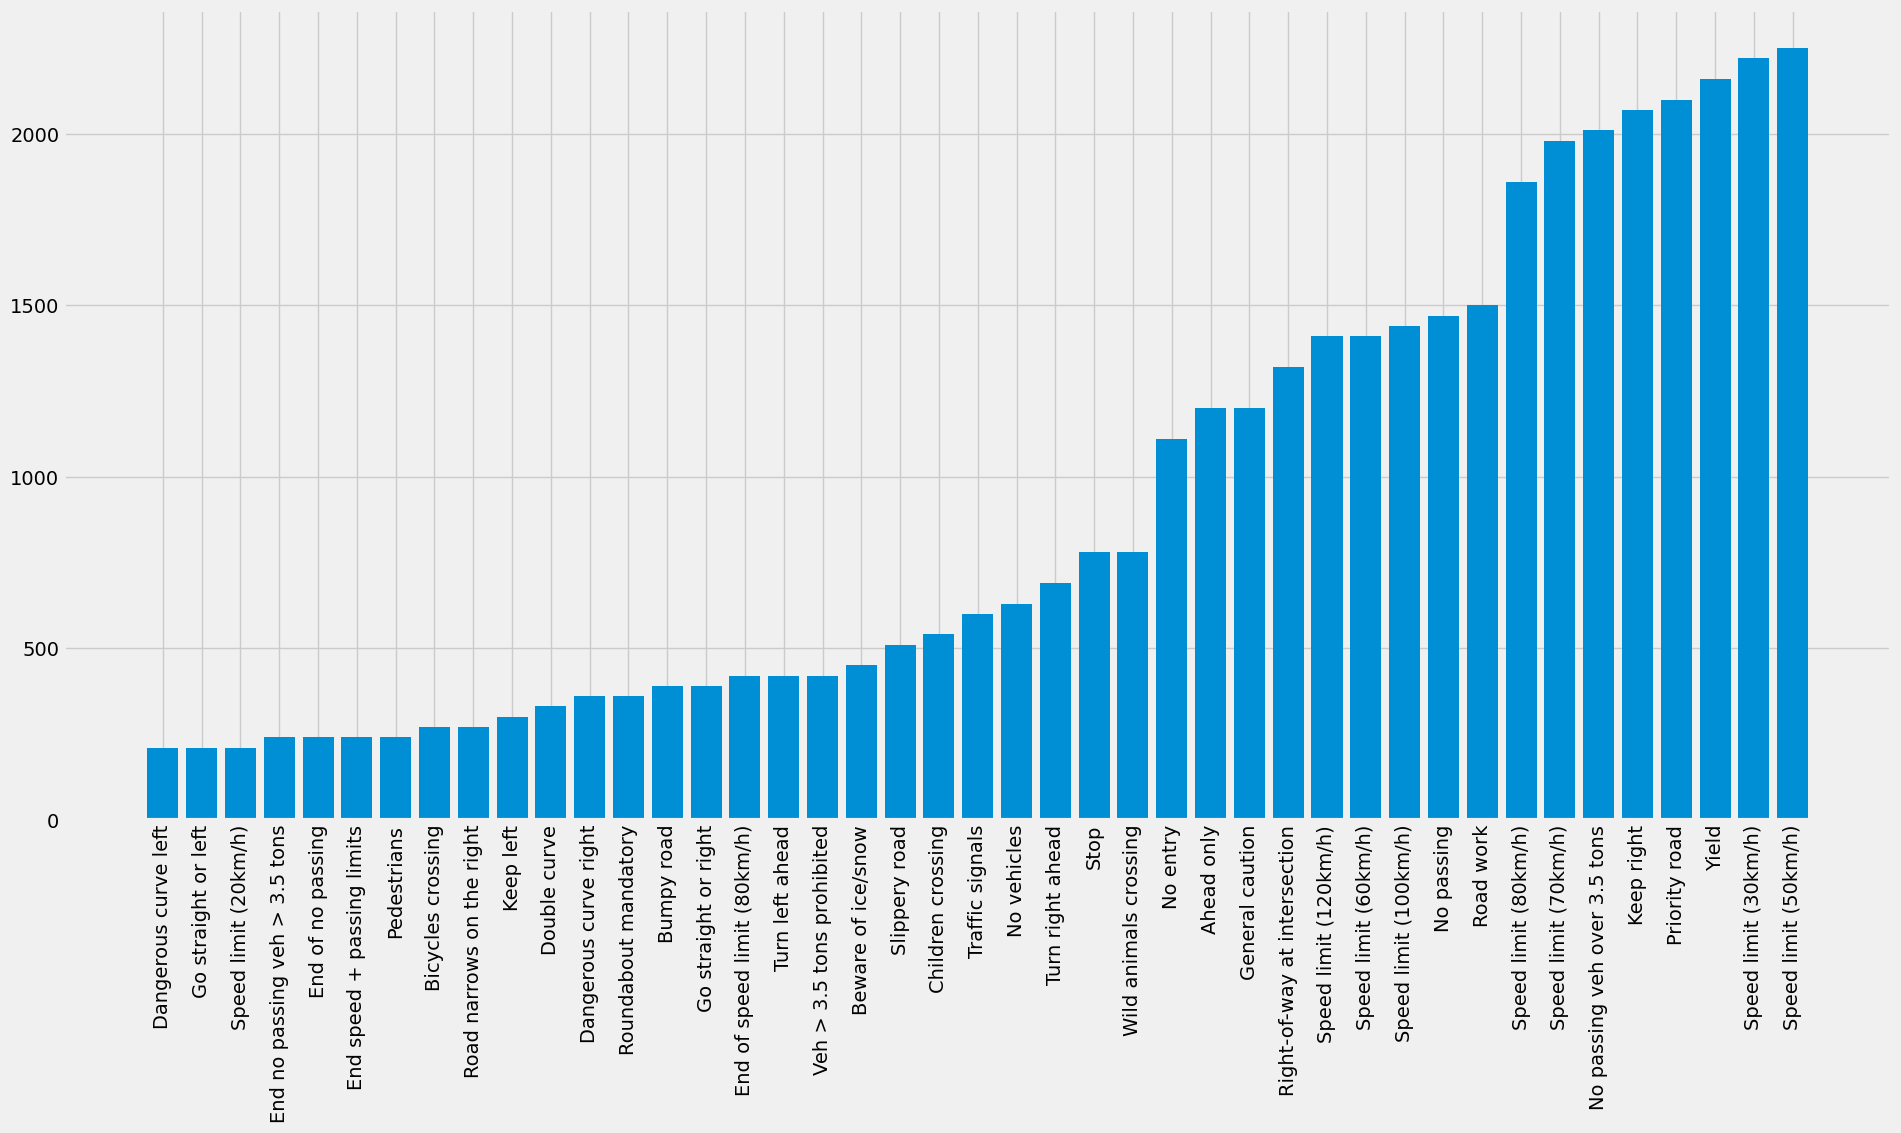

In [26]:
folders = os.listdir(train_path)

train_number = []
class_num = []

for folder in folders:
    train_files = os.listdir(train_path + '/' + folder)
    train_number.append(len(train_files))
    class_num.append(classes[int(folder)])

# Sorting the dataset on the basis of number of images in each class
zipped_lists = zip(train_number, class_num)
sorted_pairs = sorted(zipped_lists)
tuples = zip(*sorted_pairs)
train_number, class_num = [ list(tuple) for tuple in  tuples]

# Plotting the number of images in each class
plt.figure(figsize=(21,10))
plt.bar(class_num, train_number)
plt.xticks(class_num, rotation='vertical')
plt.show()

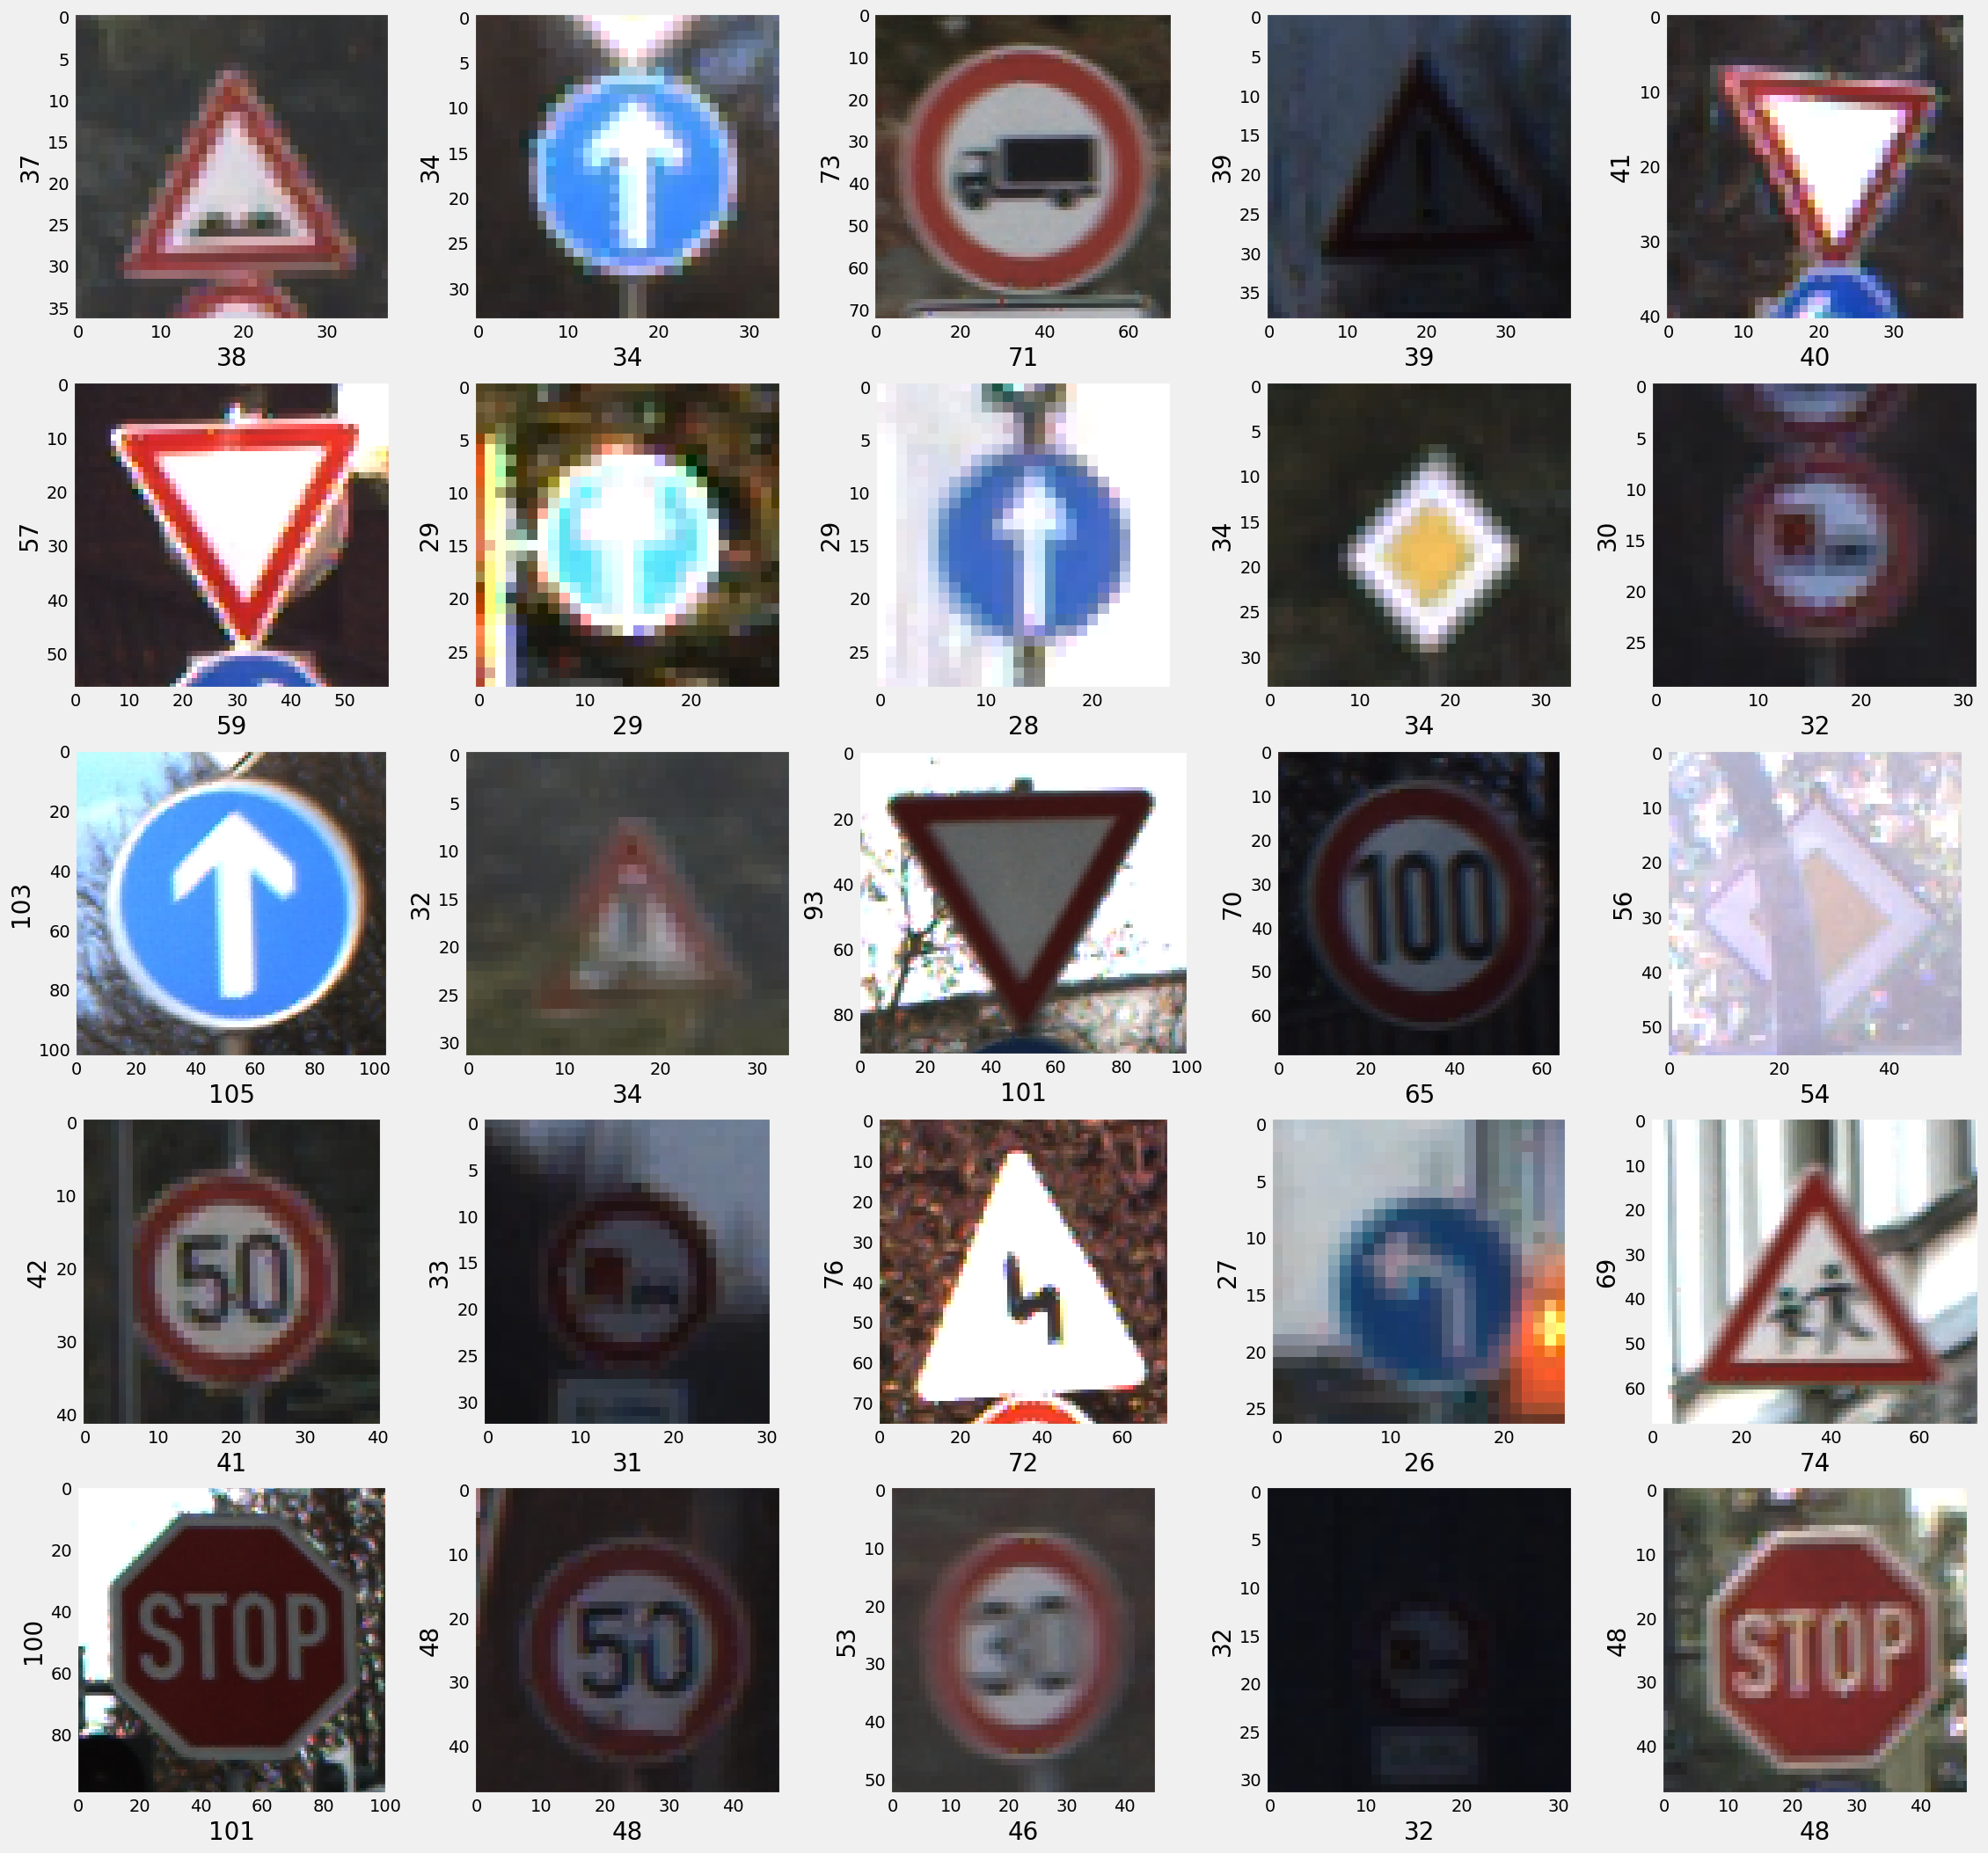

In [28]:
import random
from matplotlib.image import imread

test = pd.read_csv(data_dir + '/Test.csv')
imgs = test["Path"].values

plt.figure(figsize=(25,25))

for i in range(1,26):
    plt.subplot(5,5,i)
    random_img_path = data_dir + '/' + random.choice(imgs)
    rand_img = imread(random_img_path)
    plt.imshow(rand_img)
    plt.grid(visible=None)
    plt.xlabel(rand_img.shape[1], fontsize = 20)#width of image
    plt.ylabel(rand_img.shape[0], fontsize = 20)#height of image

In [29]:
image_data = []
image_labels = []

for i in range(NUM_CATEGORIES):
    path = data_dir + '/Train/' + str(i)
    images = os.listdir(path)

    for img in images:
        try:
            image = cv2.imread(path + '/' + img)
            image_fromarray = Image.fromarray(image, 'RGB')
            resize_image = image_fromarray.resize((IMG_HEIGHT, IMG_WIDTH))
            image_data.append(np.array(resize_image))
            image_labels.append(i)
        except:
            print("Error in " + img)

# Changing the list to numpy array
image_data = np.array(image_data)
image_labels = np.array(image_labels)

print(image_data.shape, image_labels.shape)

(39209, 30, 30, 3) (39209,)


In [30]:
shuffle_indexes = np.arange(image_data.shape[0])
np.random.shuffle(shuffle_indexes)
image_data = image_data[shuffle_indexes]
image_labels = image_labels[shuffle_indexes]

In [31]:
X_train, X_val, y_train, y_val = train_test_split(image_data, image_labels, test_size=0.3, random_state=42, shuffle=True)

# X_train = X_train/255
# X_val = X_val/255

print("X_train.shape", X_train.shape)
print("X_valid.shape", X_val.shape)
print("y_train.shape", y_train.shape)
print("y_valid.shape", y_val.shape)

X_train.shape (27446, 30, 30, 3)
X_valid.shape (11763, 30, 30, 3)
y_train.shape (27446,)
y_valid.shape (11763,)


In [32]:
y_train = keras.utils.to_categorical(y_train, NUM_CATEGORIES)
y_val = keras.utils.to_categorical(y_val, NUM_CATEGORIES)

print(y_train.shape)
print(y_val.shape)

(27446, 43)
(11763, 43)


In [33]:
model = keras.models.Sequential([
    keras.layers.Conv2D(filters=16, kernel_size=(3,3), activation='relu', input_shape=(IMG_HEIGHT,IMG_WIDTH,channels)),
    keras.layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu'),
    keras.layers.MaxPool2D(pool_size=(2, 2)),
    keras.layers.BatchNormalization(axis=-1),

    keras.layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu'),
    keras.layers.Conv2D(filters=128, kernel_size=(3,3), activation='relu'),
    keras.layers.MaxPool2D(pool_size=(2, 2)),
    keras.layers.BatchNormalization(axis=-1),

    keras.layers.Flatten(),
    keras.layers.Dense(512, activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(rate=0.5),

    keras.layers.Dense(43, activation='softmax')
])

In [34]:
lr = 0.001
epochs = 25

opt = Adam(learning_rate=lr, weight_decay=lr / (epochs * 0.5))
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

In [35]:
aug = ImageDataGenerator(
    rotation_range=10,
    zoom_range=0.15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.15,
    horizontal_flip=False,
    vertical_flip=False,
    fill_mode="nearest")

history = model.fit(aug.flow(X_train, y_train, batch_size=32), epochs=epochs, validation_data=(X_val, y_val))

Epoch 1/25
858/858 [==============================] - 32s 36ms/step - loss: 1.0756 - accuracy: 0.7121 - val_loss: 0.1301 - val_accuracy: 0.9591
Epoch 2/25
858/858 [==============================] - 28s 33ms/step - loss: 0.1993 - accuracy: 0.9390 - val_loss: 0.0392 - val_accuracy: 0.9872
Epoch 3/25
858/858 [==============================] - 29s 34ms/step - loss: 0.1216 - accuracy: 0.9639 - val_loss: 0.0369 - val_accuracy: 0.9908
Epoch 4/25
858/858 [==============================] - 30s 34ms/step - loss: 0.0918 - accuracy: 0.9719 - val_loss: 0.0170 - val_accuracy: 0.9946
Epoch 5/25
858/858 [==============================] - 32s 38ms/step - loss: 0.0871 - accuracy: 0.9726 - val_loss: 0.0607 - val_accuracy: 0.9794
Epoch 6/25
858/858 [==============================] - 32s 38ms/step - loss: 0.0759 - accuracy: 0.9771 - val_loss: 0.0296 - val_accuracy: 0.9912
Epoch 7/25
858/858 [==============================] - 31s 36ms/step - loss: 0.0693 - accuracy: 0.9785 - val_loss: 0.0172 - val_accuracy:

<function matplotlib.pyplot.show(close=None, block=None)>

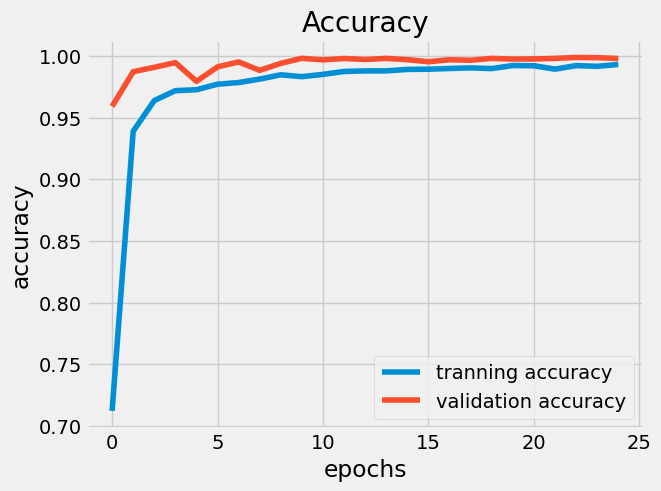

In [36]:
plt.figure(0)
plt.plot(history.history['accuracy'],label='tranning accuracy')
plt.plot(history.history['val_accuracy'],label='validation accuracy')
plt.title('Accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

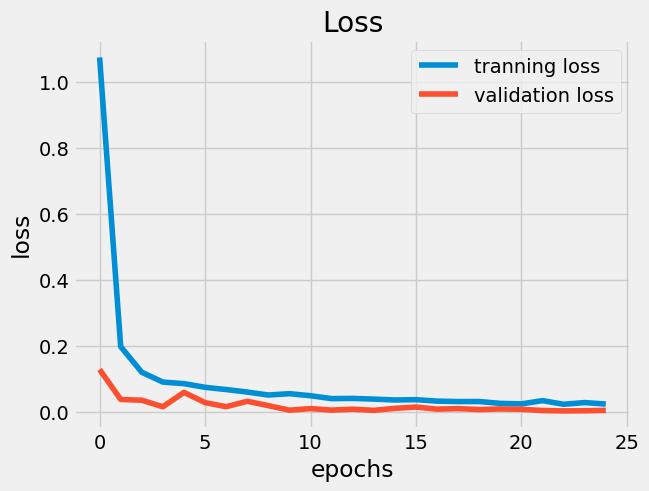

In [37]:
plt.plot(history.history['loss'],label='tranning loss')
plt.plot(history.history['val_loss'],label='validation loss')
plt.title('Loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show

In [56]:
test = pd.read_csv(data_dir + '/Test.csv')

labels = test["ClassId"].values
imgs = test["Path"].values

data =[]

for img in imgs:
    try:
        image = cv2.imread(data_dir + '/' +img)
        image_fromarray = Image.fromarray(image, 'RGB')
        resize_image = image_fromarray.resize((IMG_HEIGHT, IMG_WIDTH))
        data.append(np.array(resize_image))
    except:
        print("Error in " + img)
X_test = np.array(data)
# X_test = X_test/255


predict_x=model.predict(X_test)
pred=np.argmax(predict_x,axis=1)



#Accuracy with the test data
print('Test Data accuracy: ',accuracy_score(labels, pred)*100)

395/395 [==============================] - 2s 5ms/step
Test Data accuracy:  98.19477434679335


In [63]:
from sklearn.metrics import confusion_matrix
cf = confusion_matrix(labels, pred)
cf

array([[ 60,   0,   0, ...,   0,   0,   0],
       [  1, 718,   1, ...,   0,   0,   0],
       [  0,   1, 747, ...,   0,   0,   0],
       ...,
       [  0,   0,   0, ...,  86,   0,   0],
       [  0,   0,   0, ...,   0,  60,   0],
       [  0,   0,   0, ...,   0,   2,  88]], dtype=int64)

In [64]:
model.save("TSR.h5")

In [65]:
from keras.models import load_model
model = load_model('TSR.h5')

In [66]:
# Classes of trafic signs
classes = { 0:'Speed limit (20km/h)',
            1:'Speed limit (30km/h)',
            2:'Speed limit (50km/h)',
            3:'Speed limit (60km/h)',
            4:'Speed limit (70km/h)',
            5:'Speed limit (80km/h)',
            6:'End of speed limit (80km/h)',
            7:'Speed limit (100km/h)',
            8:'Speed limit (120km/h)',
            9:'No passing',
            10:'No passing veh over 3.5 tons',
            11:'Right-of-way at intersection',
            12:'Priority road',
            13:'Yield',
            14:'Stop',
            15:'No vehicles',
            16:'Veh > 3.5 tons prohibited',
            17:'No entry',
            18:'General caution',
            19:'Dangerous curve left',
            20:'Dangerous curve right',
            21:'Double curve',
            22:'Bumpy road',
            23:'Slippery road',
            24:'Road narrows on the right',
            25:'Road work',
            26:'Traffic signals',
            27:'Pedestrians',
            28:'Children crossing',
            29:'Bicycles crossing',
            30:'Beware of ice/snow',
            31:'Wild animals crossing',
            32:'End speed + passing limits',
            33:'Turn right ahead',
            34:'Turn left ahead',
            35:'Ahead only',
            36:'Go straight or right',
            37:'Go straight or left',
            38:'Keep right',
            39:'Keep left',
            40:'Roundabout mandatory',
            41:'End of no passing',
            42:'End no passing veh > 3.5 tons' }

In [67]:
from PIL import Image

def predict_Image(img):
    data=[]
    image=Image.open(img).resize((30,30))
    data.append(np.array(image))
    X_test = np.array(data)

    predict_x=model.predict(X_test)
    Y_pred=np.argmax(predict_x,axis=1)
    return image,Y_pred

1/1 [==============================] - 0s 104ms/step

Predicted:  Veh > 3.5 tons prohibited


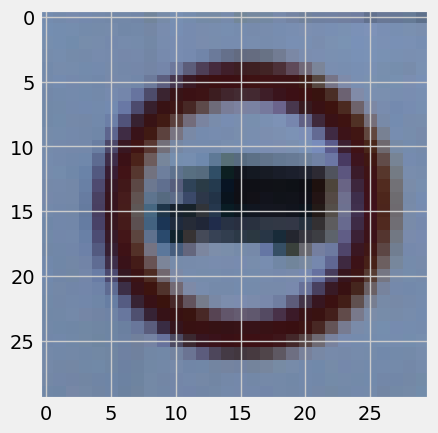

In [69]:
plot,prediction = predict_Image('D:/trafficsigndataset/Test/00000.png')
print("\nPredicted: " ,classes[prediction.item()]) #item() converts numpy int64 to native int
plt.imshow(plot)
plt.show()